In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd

In [2]:
# For aesthetics/plotting.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [14]:
from preprocess import AnomalyDetectionDataset, device_change
from model import AutoencoderAnomalyDetection, train_loop, test_loop, train_model, evaluate_model
from torch import nn

### Getting Data with pytorch

In [4]:
data_dir = '/users/eserebri/data/eserebri/PHYS2550FinalProject/anomaly detection'
train_path = f'{data_dir}/X_train.csv'
test_path = f'{data_dir}/X_test.csv'
valid_path = f'{data_dir}/X_valid.csv'

In [5]:
# Switch to GPU if there is one.
device = device_change()

Using cuda device


In [6]:
# Get train, test and validation datasets.
X_train = AnomalyDetectionDataset(train_path, three_channels=True)
X_test = AnomalyDetectionDataset(test_path, three_channels=True)
X_valid = AnomalyDetectionDataset(valid_path, three_channels=True)

### Model Implementation

In [7]:
# Hyperparameters.
learning_rate = 1e-5
weight_decay = 1e-3 # For l2 regularization.
batch_size = 350
epochs = 50

In [8]:
# torch.utils.DataLoader.
torch.manual_seed(42)
X_train_dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
X_test_dataloader = DataLoader(X_test, batch_size=batch_size, shuffle=True)
X_valid_dataloader = DataLoader(X_valid, batch_size=batch_size, shuffle=True)

In [9]:
# Choose model, loss function, optimizer, and scheduler.
model = AutoencoderAnomalyDetection().to(device)
print(model)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = exp_scheduler(optimizer=optimizer, gamma=0.95) # If we use a scheduled learning rate.

AutoencoderAnomalyDetection(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2100, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=2100, bias=True)
    (10): Unflatten(dim=1, unflattened_size=[3

### Training Model

Epoch 1
-------------------------------
loss: 2.907181  [  350/680000]
loss: 0.560600  [ 3550/680000]
loss: 0.423895  [ 6750/680000]
loss: 0.539023  [ 9950/680000]
loss: 0.536799  [13150/680000]
loss: 0.509677  [16350/680000]
loss: 2.346566  [19550/680000]
loss: 0.397528  [22750/680000]
loss: 0.605151  [25950/680000]
loss: 0.521702  [29150/680000]
loss: 0.544180  [32350/680000]
loss: 0.440449  [35550/680000]
loss: 0.592816  [38750/680000]
loss: 0.445329  [41950/680000]
loss: 0.517760  [45150/680000]
loss: 0.441960  [48350/680000]
loss: 0.841623  [51550/680000]
loss: 0.499568  [54750/680000]
loss: 0.489900  [57950/680000]
loss: 0.488309  [61150/680000]
Average train loss over the number of batches: 0.770120 

Average test loss over the number of batches: 0.875372 

Done!
Epoch 2
-------------------------------
loss: 0.541450  [  350/680000]
loss: 0.780190  [ 3550/680000]
loss: 0.573124  [ 6750/680000]
loss: 0.501485  [ 9950/680000]
loss: 0.623621  [13150/680000]
loss: 1.334580  [16350/6

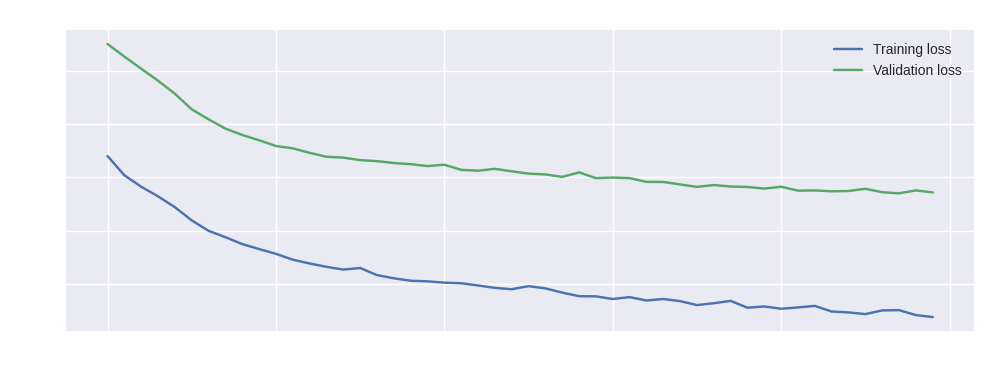

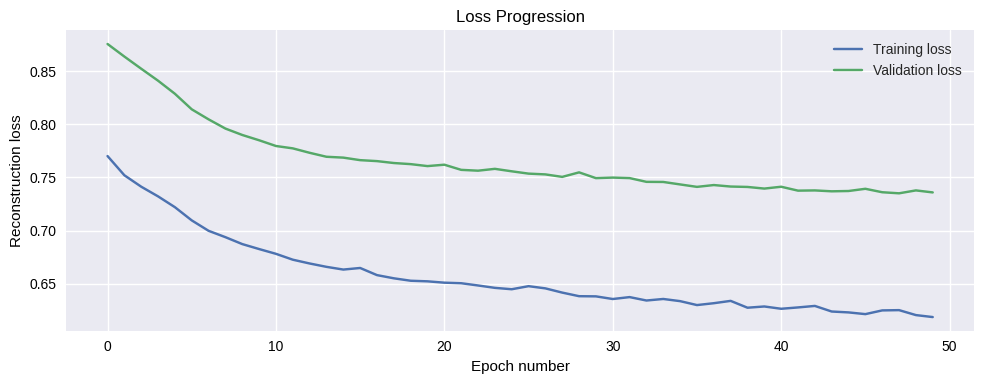

In [10]:
# Train the model on the background data.
train_loss, valid_loss = train_model(
    X_train_dataloader, 
    X_valid_dataloader, 
    model, 
    loss_func, 
    optimizer, 
    epochs, 
    scheduler=None,
    batch_size=batch_size, 
    graph_path=f'{data_dir}/graphs/testing.png'
)

#### Saving Model Parameters

In [17]:
PATH = f'{data_dir}/model_par/autoencoder_state_dict.pth'
torch.save(model.state_dict(), PATH)

### Making Predictions

In [12]:
# Load the model state dictionary.
# model = AutoencoderAnomalyDetection().to(device)
# model.load_state_dict(torch.load(PATH))
# model.state_dict()

In [15]:
# Predictions.
test_loss = evaluate_model(
    X_test_dataloader,
    model,
    loss_func,
    batch_size=batch_size
)

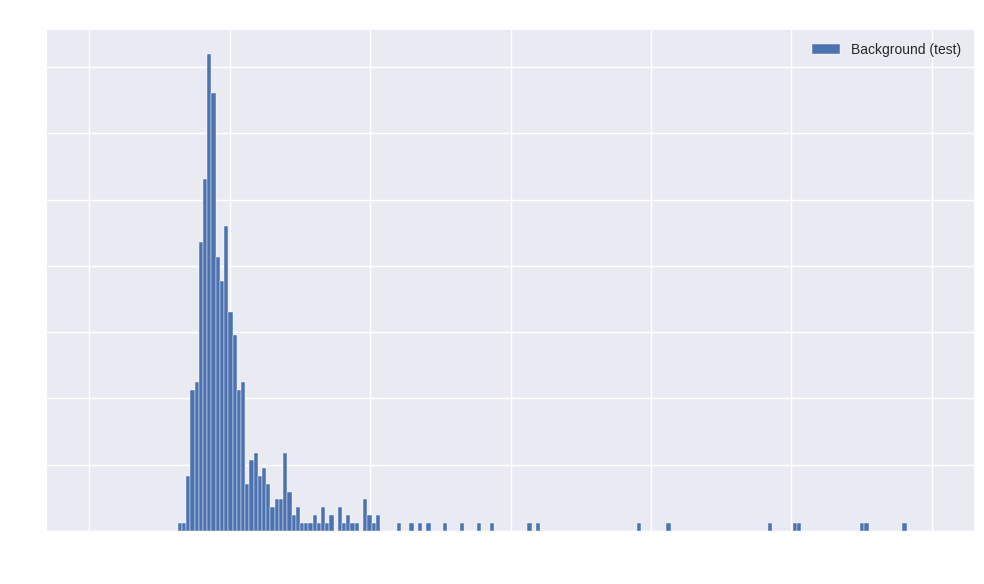

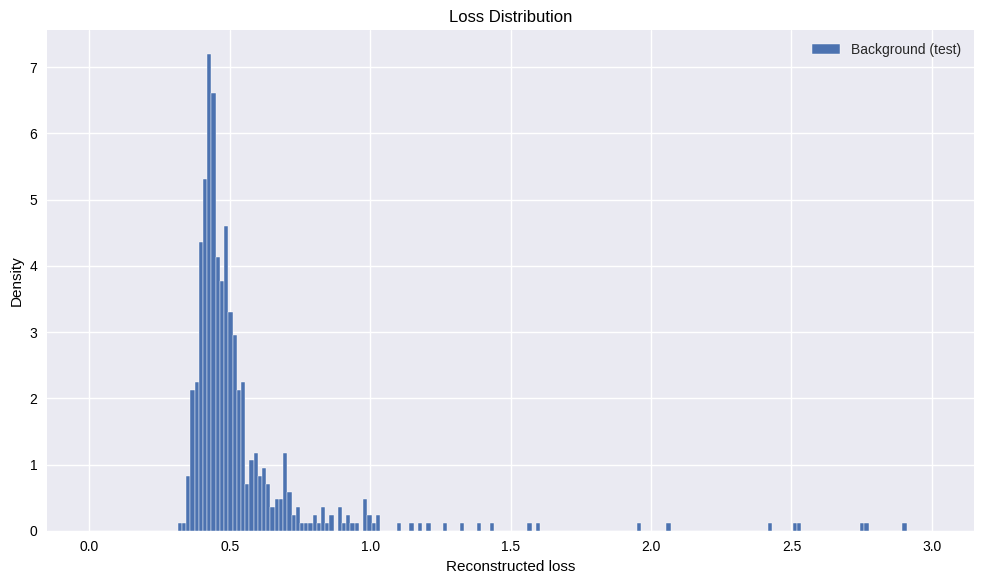

In [35]:
graph_text_face = [('white', 'none'), ('black', 'white')]
for (text_color, face_color) in graph_text_face:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
    plt.hist(test_loss, bins=200, range=(0,3), label='Background (test)', density=True)
    ax.set_title("Loss Distribution", color=text_color)
    ax.set_xlabel("Reconstructed loss", color=text_color)
    ax.set_ylabel("Density", color=text_color)
    ax.legend(facecolor=face_color)
    ax.tick_params(axis='both', colors=text_color)
    plt.tight_layout()
    plt.savefig(f'{data_dir}/graphs/background_loss_density_{face_color}.png', dpi=600, bbox_inches='tight')
plt.show()

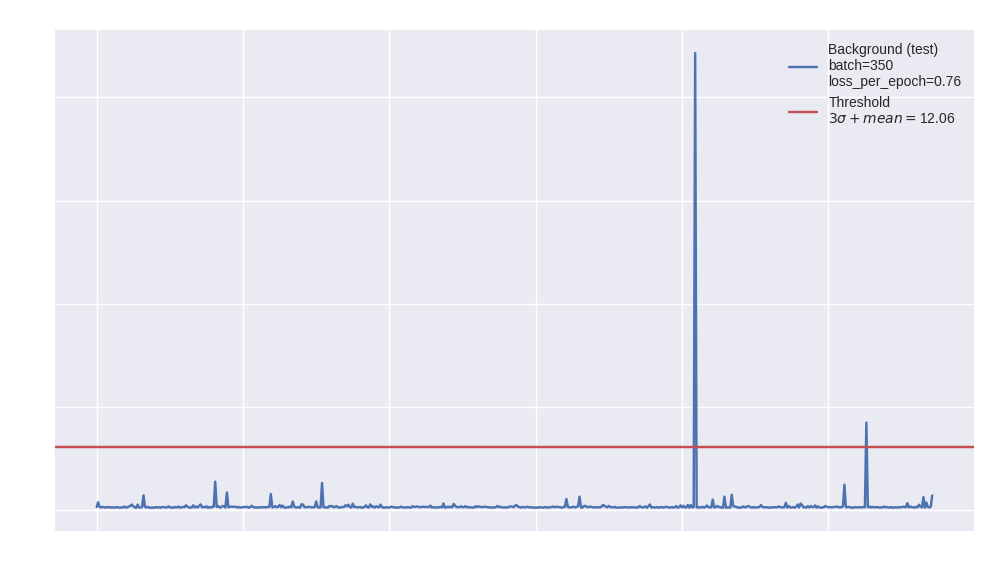

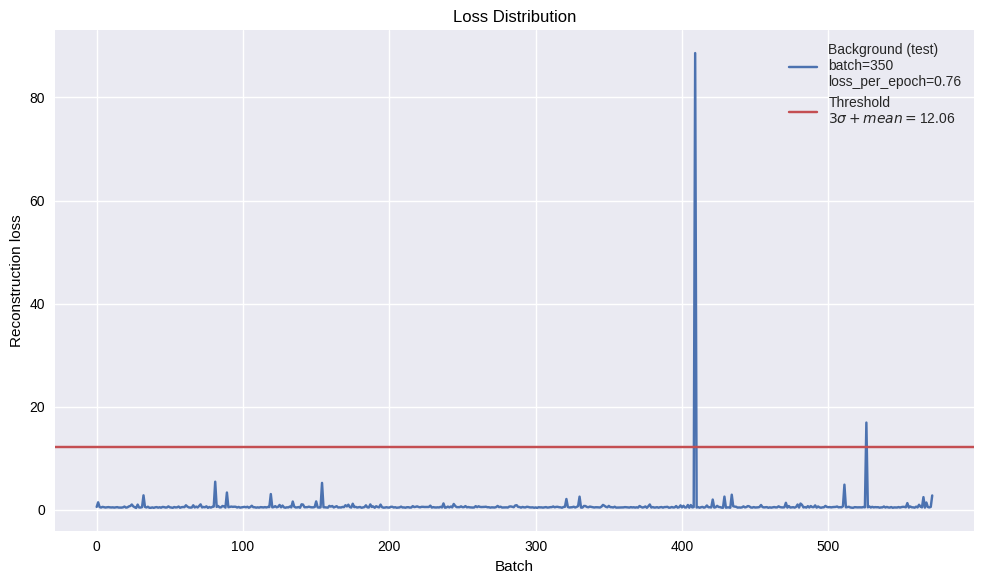

In [49]:
threshold = 3 * test_loss.std() + test_loss.mean()
graph_text_face = [('white', 'none'), ('black', 'white')]
for (text_color, face_color) in graph_text_face:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
    plt.plot(test_loss, label=f'Background (test)\nbatch={batch_size}\nloss_per_epoch={test_loss.mean():.2f}')
    plt.axhline(threshold, color=sns.color_palette()[2], label=f'Threshold\n$3\sigma+mean=${threshold:.2f}')
    ax.set_title("Loss Distribution", color=text_color)
    plt.legend('best')
    ax.set_xlabel("Batch", color=text_color)
    ax.set_ylabel("Reconstruction loss", color=text_color)
    ax.legend(facecolor=face_color)
    ax.tick_params(axis='both', colors=text_color)
    plt.tight_layout()
    plt.savefig(f'{data_dir}/graphs/background_loss_batch_{face_color}.png', dpi=600, bbox_inches='tight')
plt.show()
# false positive: statistical anomaly